# 401 CNN

View more, visit my tutorial page: https://morvanzhou.github.io/tutorials/
My Youtube Channel: https://www.youtube.com/user/MorvanZhou

Dependencies:
* torch: 0.1.11
* torchvision
* matplotlib

In [1]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.optim import Adam, SGD

In [2]:
# Load training data set (small amount to test if it works first)

xtrain = r"data/training_sample2.csv.gz"
ytrain = r"data/training_label2_int.csv.gz"
xtest = r"data/testing_sample2.csv.gz"
ytest = r"data/testing_label2_int.csv.gz"

samplesdf = pd.read_csv(xtrain,compression ="gzip",delimiter=',', nrows = 500, header=0)
x_train = samplesdf.to_numpy()

samplesdf = pd.read_csv(ytrain,compression ="gzip",delimiter=',', nrows = 500, header=0)
y_train = samplesdf.to_numpy()

samplesdf = pd.read_csv(xtest,compression ="gzip",delimiter=',',nrows = 500, header=0)
x_test = samplesdf.to_numpy()

samplesdf = pd.read_csv(ytest,compression ="gzip",delimiter=',', nrows = 500, header=0)
y_test = samplesdf.to_numpy()
print("done")

t , dummy = x_train.shape
k, dummy = x_test.shape
x_train = x_train.reshape(t,1,8949)
x_test = x_test.reshape(k,1,8949)
y_train = y_train.reshape(t)
y_test = y_test.reshape(k)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


done
(500, 1, 8949)
(500, 1, 8949)
(500,)
(500,)


In [3]:
#convert into torch format
x_train = torch.from_numpy(x_train).double()
y_train = torch.from_numpy(y_train).long()
x_train.shape,y_train.shape             

(torch.Size([500, 1, 8949]), torch.Size([500]))

In [4]:
#convert into torch format
x_test = torch.from_numpy(x_test).double()
y_test = torch.from_numpy(y_test).long()
x_test.shape,y_test.shape        

(torch.Size([500, 1, 8949]), torch.Size([500]))

In [5]:
# Hyper Parameters
EPOCH = 25             # train the training data n times, to save time, we just train 1 epoch
LR = 0.001              # learning rate


In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (x,1, 8949)
            nn.Conv1d(
                in_channels=1,              # input height
                out_channels=4,            # n_filters
                kernel_size=3,              # filter size
                stride=1,                   # filter movement/step
                padding=1,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (x,64,8949)
            nn.BatchNorm1d(4),
            nn.ReLU(),                      # activation
        )
        self.conv2 = nn.Sequential(         # input shape (x,64, 8949)
            nn.Conv1d(4,4,3,1,1),            
            nn.ReLU(),  
            nn.Dropout(p=0.4),
            nn.MaxPool1d(kernel_size =2, stride=2,ceil_mode = True),                # output shape (x,64,4478)
        )
        self.conv3 = nn.Sequential(         # input shape (x,64,4478)
            nn.Conv1d(4, 4, 3, 1, 1),     # output shape (x,128,4478)
            nn.ReLU(),                      # activation
            nn.MaxPool1d(kernel_size =2, stride=2,ceil_mode = True),                # output shape (x,128,2238)
        )
        self.out = nn.Linear(17900 , 7)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        s = self.conv3(x)
        x = x.view(x.size(0), -1)           
        output = self.out(x)
        return output  

In [7]:
cnn = CNN()
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted
if torch.cuda.is_available():
    cnn = cnn.cuda()
    loss_func = loss_func.cuda()
cnn = cnn.double()    
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv1d(1, 4, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv1d(4, 4, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  )
  (conv3): Sequential(
    (0): Conv1d(4, 4, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  )
  (out): Linear(in_features=17900, out_features=7, bias=True)
)


In [8]:
def train(epoch):
    cnn.train()
    tr_loss = 0
    # getting the training set
    xtrain, ytrain = Variable(x_train), Variable(y_train)
    # getting the validation set
    xval, yval = Variable(x_test), Variable(y_test)
    # converting the data into GPU format
    if torch.cuda.is_available():
        xtrain = xtrain.cuda()
        ytrain = ytrain.cuda()
        xval = xval.cuda()
        yval = yval.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = cnn(xtrain.double())
    output_val = cnn(xval.double())

    # computing the training and validation loss
    loss_train = loss_func(output_train, ytrain)
    loss_val = loss_func(output_val, yval)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

In [9]:
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(EPOCH):
    train(epoch)
print("Done")

Epoch :  1 	 loss : tensor(1.9672, dtype=torch.float64, grad_fn=<NllLossBackward>)
Epoch :  3 	 loss : tensor(3.0734, dtype=torch.float64, grad_fn=<NllLossBackward>)
Epoch :  5 	 loss : tensor(2.5274, dtype=torch.float64, grad_fn=<NllLossBackward>)
Epoch :  7 	 loss : tensor(2.2366, dtype=torch.float64, grad_fn=<NllLossBackward>)
Epoch :  9 	 loss : tensor(1.9926, dtype=torch.float64, grad_fn=<NllLossBackward>)
Epoch :  11 	 loss : tensor(1.8435, dtype=torch.float64, grad_fn=<NllLossBackward>)
Epoch :  13 	 loss : tensor(1.8943, dtype=torch.float64, grad_fn=<NllLossBackward>)
Epoch :  15 	 loss : tensor(1.7584, dtype=torch.float64, grad_fn=<NllLossBackward>)
Epoch :  17 	 loss : tensor(1.8063, dtype=torch.float64, grad_fn=<NllLossBackward>)
Epoch :  19 	 loss : tensor(1.6782, dtype=torch.float64, grad_fn=<NllLossBackward>)
Epoch :  21 	 loss : tensor(1.6663, dtype=torch.float64, grad_fn=<NllLossBackward>)
Epoch :  23 	 loss : tensor(1.6572, dtype=torch.float64, grad_fn=<NllLossBackward

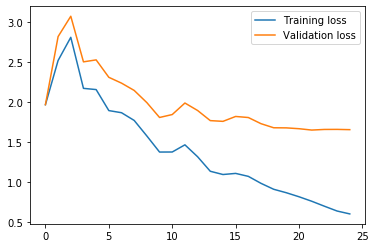

In [10]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

In [11]:
# prediction for testing set
with torch.no_grad():
    output = cnn(x_train)
    
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on testing set
accuracy_score(y_train, predictions)

0.842

In [12]:
# prediction for testing set
with torch.no_grad():
    output = cnn(x_test)
    
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on testing set
accuracy_score(y_test, predictions)

0.436